In [5]:
import json, time, re, nltk, hdbscan, spacy, string
import psycopg2 as pg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sys import getsizeof
from datetime import datetime
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from psycopg2.extras import RealDictCursor, Json
from spacy.lang.en.examples import sentences

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

np.random.seed(42)

%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [6]:
%run sql_test.py

In [7]:
def con_cur_to_db(dbname=DBNAME, dict_cur=None):
    ''' 
    Returns both a connection and a cursor object for your database
    '''

    con = pg2.connect(host=IP_ADDRESS, #allows you to navigate db
                  dbname=dbname,
                  user=USER,
                  password=PASSWORD)
    if dict_cur:
        cur = con.cursor(cursor_factory=RealDictCursor)
    else:
        cur = con.cursor()
    return con, cur
    
def execute_query(query, dbname=DBNAME, dict_cur=None, command=False):
    '''
    Executes a query directly to a database, without having to create a cursor and connection each time. 
    '''
    con, cur = con_cur_to_db(dbname, dict_cur)
    cur.execute(f'{query}')
    if not command:
        data = cur.fetchall()
        con.close()
        return data
    con.commit() #sends to server
    con.close() #closes server connection

def insert_entry_json(data, tablename=None):
    con, cur = con_cur_to_db()
    for x in data:
        cur.execute(f'INSERT INTO {tablename} (data) VALUES ({Json(x)});')
    con.commit()
    con.close()

In [8]:
query = """SELECT data->>'text'
FROM raw_tweets;
"""
response = execute_query(query, dict_cur=True)

df = pd.DataFrame(response).drop_duplicates()

In [9]:
df.columns = ['text']

In [10]:
df.shape

(21422, 1)

In [11]:
def processTweet(tweet):
    #Convert to lower case
    tweet = tweet.lower()
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    #Eliminate hastags
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #Remove @ signs
    tweet = re.sub('@', '', tweet)
    return tweet

In [12]:
tweet_list = [i for i in df['text']]

In [13]:
tweet_list[:5]

['On a positive note the doctor told me I only gained 32 pounds my entire pregnancy 🙌🏼',
 'The Gathering coming to the Hilton University Place in Charlotte NC August 15th- 18th 2019. Many great legends will… https://t.co/LsWkWjsp6p',
 'RT @pun8o: プレゼント企画✨\n\nディズニー [チケット]🎫\n\n応募\u3000→\u3000フォロー&amp;リツイート\n結果\u3000→\u3000当選者にはDMでお知らせします\n\n６名の当選となります！\n応募期限は今月末までです🌟 https://t.co/QqudI9A7zu',
 'RT @mitchellvii: CREEP SHOW: Pelosi and Schumer Freak Out Viewers... Blank Stares, Scowls and Crazy Eyes Consume Dem Response (VIDEO) https…',
 "@MarvelStudios @iKBoy I dont see how ppl can say they don't think she'll be good in this movie lol"]

Create a column of processed tweets utilizing the created function above:

In [14]:
df['processed'] = [processTweet(i) for i in tweet_list]

In [119]:
df['processed'].str.contains('timberlake').sum()

40

In [16]:
tokenizer = RegexpTokenizer(r'\w+')

In [17]:
df['clean_processed'] = df['processed'].map(lambda x: tokenizer.tokenize(x))

In [18]:
df.head()

,text,processed,clean_processed
0,On a positive note the doctor told me I only g...,on a positive note the doctor told me i only g...,"[on, a, positive, note, the, doctor, told, me,..."
1,The Gathering coming to the Hilton University ...,the gathering coming to the hilton university ...,"[the, gathering, coming, to, the, hilton, univ..."
2,RT @pun8o: プレゼント企画✨\n\nディズニー [チケット]🎫\n\n応募 → フ...,rt pun8o: プレゼント企画✨ ディズニー [チケット]🎫 応募 → フォロー&amp...,"[rt, pun8o, プレゼント企画, ディズニー, チケット, 応募, フォロー, am..."
3,RT @mitchellvii: CREEP SHOW: Pelosi and Schume...,rt mitchellvii: creep show: pelosi and schumer...,"[rt, mitchellvii, creep, show, pelosi, and, sc..."
4,@MarvelStudios @iKBoy I dont see how ppl can s...,marvelstudios ikboy i dont see how ppl can say...,"[marvelstudios, ikboy, i, dont, see, how, ppl,..."


In [19]:
lemmatizer = WordNetLemmatizer()

In [20]:
df['lemm_clean_processed'] = df['clean_processed'].map(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))

In [21]:
df.head()

,text,processed,clean_processed,lemm_clean_processed
0,On a positive note the doctor told me I only g...,on a positive note the doctor told me i only g...,"[on, a, positive, note, the, doctor, told, me,...",on a positive note the doctor told me i only g...
1,The Gathering coming to the Hilton University ...,the gathering coming to the hilton university ...,"[the, gathering, coming, to, the, hilton, univ...",the gathering coming to the hilton university ...
2,RT @pun8o: プレゼント企画✨\n\nディズニー [チケット]🎫\n\n応募 → フ...,rt pun8o: プレゼント企画✨ ディズニー [チケット]🎫 応募 → フォロー&amp...,"[rt, pun8o, プレゼント企画, ディズニー, チケット, 応募, フォロー, am...",rt pun8o プレゼント企画 ディズニー チケット 応募 フォロー amp リツイート ...
3,RT @mitchellvii: CREEP SHOW: Pelosi and Schume...,rt mitchellvii: creep show: pelosi and schumer...,"[rt, mitchellvii, creep, show, pelosi, and, sc...",rt mitchellvii creep show pelosi and schumer f...
4,@MarvelStudios @iKBoy I dont see how ppl can s...,marvelstudios ikboy i dont see how ppl can say...,"[marvelstudios, ikboy, i, dont, see, how, ppl,...",marvelstudios ikboy i dont see how ppl can say...


In [79]:
df.shape

(21422, 4)

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21422 entries, 0 to 289770
Data columns (total 4 columns):
text                    21422 non-null object
processed               21422 non-null object
clean_processed         21422 non-null object
lemm_clean_processed    21422 non-null object
dtypes: object(4)
memory usage: 1.4+ MB


In [22]:
lemm_clean_processed_list = [i for i in df['lemm_clean_processed']]

Utilize countvectorizer:

min_df will remember words that are in a document at least once. For example, if min_df = 3, will only remember words that are a part of 3 documents in a corpus. max_df refers to the %-age of documents within a corpus that a word occurs in. For example, if max_df = 0.9, words that occur in more than 90% of my documents will be ignored. By default, max_df is equal to 1.

In [23]:
cv = CountVectorizer(ngram_range = (1,2),
                     stop_words = 'english',
                     min_df = 15,
                     max_df = 1.0)

In [24]:
df_cv = pd.SparseDataFrame(cv.fit_transform(df['lemm_clean_processed']), 
                     columns = cv.get_feature_names())

In [25]:
getsizeof(df_cv)

885512

In [26]:
df_cv.fillna(0, inplace=True)

In [27]:
df_cv.columns

Index(['00', '000', '01', '07', '10', '100', '11', '110', '110 free', '12',
       ...
       'york', 'young', 'younger', 'yourvoice', 'yourvoice america', 'youtube',
       'youtube playlist', 'youtube video', 'zero', 'zip'],
      dtype='object', length=1880)

Perform SVD to reduce dimensionality to about ~1000 (Currently ~1800)...Have to run an instance with about ~8GB of RAM (~0.08cents to perform one calculation); shut off the instance and restart this instance.. 

tfidf dataframe

custom_stop = ['url',
               'rt',
               'mitchellvii',
               'wa',
               'ha',
               'just',
               'good',
               'free',
               'purchase',
               'shipping',
               'don',
               'buy',
               'sale',
               'snkrconnecthq',
               
              ]

stop_words = ENGLISH_STOP_WORDS.union(custom_stop)

In [28]:
tfidf = TfidfVectorizer(ngram_range=(1,2), 
                        stop_words = 'english', 
                        min_df = 25, 
                        max_df = 1.0)

In [29]:
df_tfidf = pd.SparseDataFrame(tfidf.fit_transform(df['lemm_clean_processed']),
                        columns = tfidf.get_feature_names())

In [30]:
df_tfidf.shape

(21422, 1056)

In [31]:
df_tfidf.fillna(0, inplace = True)

In [32]:
df_tfidf.head()

,00,000,10,100,11,12,120,13,130,130 free,...,year url,yep,yes,yesterday,yo,young,youtube,youtube playlist,youtube video,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### SVD

In [33]:
SVD = TruncatedSVD(n_components=1000) 
# doesn't center out data...versus PCA which it does...
# ##If we didn't fit before train_test_split (WHY DO WE NEED TO FIT TRANSFORM BEFORE TRAIN TEST SPLIT...)
svd_matrix = SVD.fit_transform(df_tfidf)
svd_matrix.shape

(21422, 1000)

In [34]:
component_names = pd.Series(["component_"+str(i+1) for i in range(1000)])

In [35]:
SVD.components_.shape

(1000, 1056)

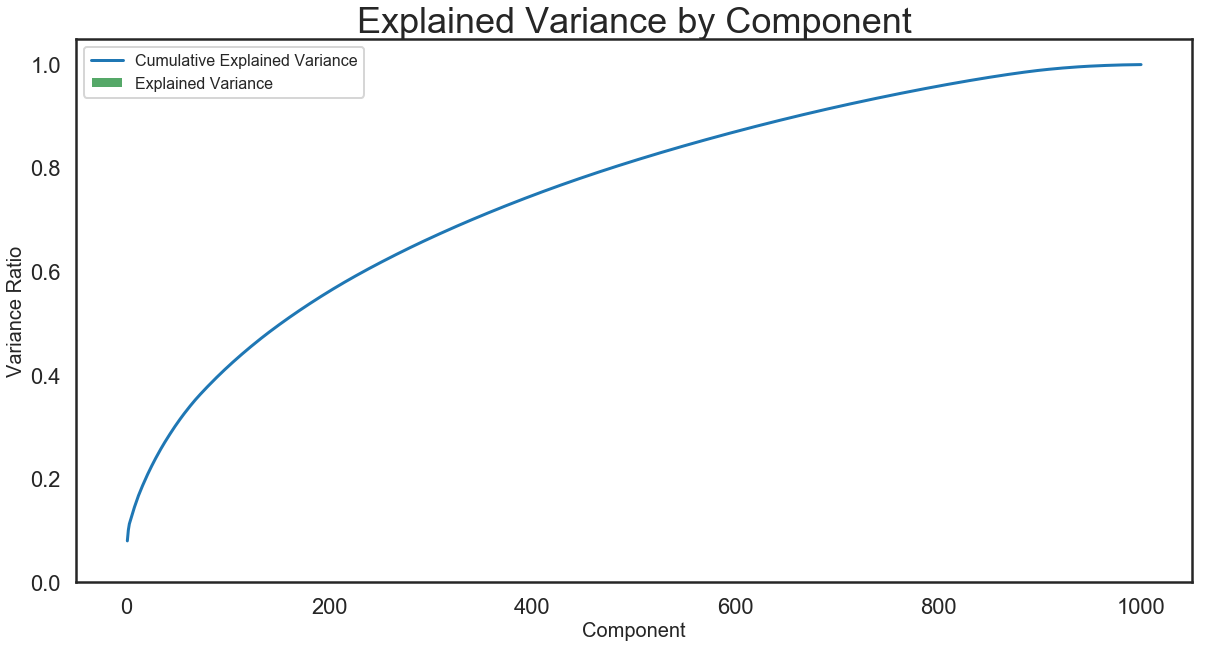

In [39]:
fig = plt.figure(figsize=(20,10))
plt.bar(np.array(range(1000))+1, 
        SVD.explained_variance_ratio_, 
        color='g', 
        label='Explained Variance')
plt.plot(np.array(range(1000))+1, 
         np.cumsum(SVD.explained_variance_ratio_), 
         label='Cumulative Explained Variance')
plt.legend(fontsize=16)
plt.xlabel('Component', fontsize=20)
plt.ylabel('Variance Ratio', fontsize=20)
plt.title('Explained Variance by Component', fontsize=36);

In [41]:
np.cumsum(SVD.explained_variance_)

array([0.07277584, 0.09190323, 0.10268834, 0.10860638, 0.11485275,
       0.12080174, 0.12650296, 0.13204213, 0.13721215, 0.14242354,
       0.1474821 , 0.15243225, 0.15686774, 0.16129233, 0.16559715,
       0.16985583, 0.1739408 , 0.17800312, 0.18199848, 0.18593369,
       0.18980081, 0.19358001, 0.19734758, 0.20096185, 0.20449415,
       0.20801397, 0.21149804, 0.21492402, 0.2182592 , 0.22156527,
       0.22483169, 0.22806543, 0.231258  , 0.23440684, 0.23750351,
       0.2405346 , 0.24349856, 0.24645827, 0.24936262, 0.25220796,
       0.25504266, 0.25785496, 0.26064842, 0.26341141, 0.26614736,
       0.26884709, 0.2715332 , 0.27417421, 0.27675895, 0.27932658,
       0.28185922, 0.28437563, 0.28685701, 0.28933418, 0.29176295,
       0.29414032, 0.29649295, 0.29880987, 0.30111443, 0.3033929 ,
       0.30564876, 0.30789135, 0.3101118 , 0.31230184, 0.31448717,
       0.31661873, 0.31872395, 0.32077731, 0.32281526, 0.32483289,
       0.32681885, 0.32876121, 0.33070939, 0.33263592, 0.33454

In [42]:
component_names = ["component_"+str(i+1) for i in range(1000)]
svd_df = pd.SparseDataFrame(svd_matrix,columns=component_names)

In [43]:
svd_df.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_991,component_992,component_993,component_994,component_995,component_996,component_997,component_998,component_999,component_1000
0,0.000763,0.003600,-0.000719,0.013132,0.000306,0.004348,-0.000667,0.000021,0.002468,-0.002633,...,0.000068,0.000252,0.000150,0.000381,0.000669,0.000307,-0.001478,0.000684,0.000034,-0.000204
1,0.104693,0.008187,-0.000663,0.053874,0.004920,0.005132,-0.023113,0.003995,0.052652,-0.017968,...,0.000951,0.000195,0.001228,-0.000440,0.000225,0.001832,-0.004197,0.001264,0.000323,0.000234
2,0.361589,0.459405,-0.018528,-0.011607,0.019071,-0.016191,-0.004097,-0.021493,0.059154,-0.003334,...,0.000463,-0.000300,-0.000591,-0.000767,0.000306,-0.000057,-0.000370,-0.000374,-0.000041,-0.001863
3,0.017566,0.161691,-0.014753,0.018574,-0.007673,-0.001119,-0.011162,-0.012572,0.005956,-0.000798,...,-0.000543,0.002232,-0.001896,-0.002930,-0.003844,0.000578,-0.002813,0.001696,-0.002092,-0.000369
4,0.008087,0.028835,-0.008641,0.213131,-0.022344,-0.036412,0.057618,0.009185,0.232568,0.137481,...,0.000072,-0.000043,-0.000096,0.000480,0.000212,0.000248,0.000311,0.000276,0.000152,0.000239


In [44]:
loadings = pd.SparseDataFrame(SVD.components_,
                              index=component_names,
                              columns=df_tfidf.columns).T

In [45]:
loadings['abs_component_1'] = np.abs(loadings.component_1)
loadings['abs_component_2'] = np.abs(loadings.component_2)
loadings['abs_component_3'] = np.abs(loadings.component_3)
loadings['abs_component_4'] = np.abs(loadings.component_4)

In [46]:
loadings.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_995,component_996,component_997,component_998,component_999,component_1000,abs_component_1,abs_component_2,abs_component_3,abs_component_4
00,0.000778,0.001449,-0.000124,0.004630,-0.000716,0.001178,0.000149,0.000199,0.012501,-0.010824,...,-0.000837,-0.000173,-0.000774,0.000719,-0.000272,0.000042,0.000778,0.001449,0.000124,0.004630
000,0.001080,0.005306,-0.000519,0.005720,-0.000432,-0.001776,-0.002579,0.004127,0.004204,-0.002673,...,-0.000627,-0.000134,0.002362,0.000606,-0.004150,-0.000127,0.001080,0.005306,0.000519,0.005720
10,0.002954,0.009496,0.009391,0.016573,-0.002950,-0.001380,-0.006681,-0.000409,0.012022,-0.008319,...,0.000064,0.001081,0.001786,-0.003420,0.000509,-0.000325,0.002954,0.009496,0.009391,0.016573
100,0.001452,0.004386,0.013690,0.008116,-0.001502,-0.002334,0.006076,-0.000299,-0.000368,0.001890,...,0.000225,-0.018638,0.001597,0.000572,0.000101,0.000163,0.001452,0.004386,0.013690,0.008116
11,0.001051,0.004584,0.001693,0.006550,-0.001599,0.002068,-0.000224,-0.000224,0.007772,-0.005277,...,0.000373,-0.000138,0.001359,0.001487,-0.000102,0.000200,0.001051,0.004584,0.001693,0.006550


In [47]:
loadings.sort_values('abs_component_1',ascending=False).head(20)[['component_1']]

,component_1
url,0.992409
rt,0.103699
url url,0.034879
just,0.012125
new,0.009599
like,0.009184
amp,0.009029
wa,0.008999
love,0.008762
time,0.007926


In [48]:
loadings.sort_values('abs_component_2',ascending=False).head(20)[['component_2']]

,component_2
rt,0.969221
url,-0.112232
mitchellvii,0.043501
rt mitchellvii,0.043293
amp,0.039612
available,0.038678
just,0.038083
purchase,0.036648
free,0.036524
available purchase,0.036383


In [49]:
loadings.sort_values('abs_component_3',ascending=False).head(20)[['component_3']]

,component_3
available,0.316487
purchase,0.309632
available purchase,0.308289
free,0.305371
buy,0.297164
shipping,0.287911
shipping buy,0.280864
free shipping,0.269851
buy url,0.253548
nike,0.162117


In [50]:
loadings.sort_values('abs_component_4',ascending=False).head(20)[['component_4']]

,component_4
just,0.418255
like,0.387160
wa,0.369792
don,0.227332
know,0.217200
love,0.182656
good,0.163646
lol,0.160097
rt,-0.151910
time,0.132907


In [112]:
cos_sim_mat = cosine_similarity(svd_df, svd_df)
cos_sim_mat.shape

(21422, 21422)

In [52]:
np.argsort(cos_sim_mat[1])[:-11:-1]

array([    1,  5962, 10830,    25, 10604,  3474, 21286,  5793,  9679,
        4881])

In [53]:
np.sort(cos_sim_mat[1])[:-11:-1]

array([1.        , 0.7038541 , 0.7038541 , 0.68349388, 0.59607281,
       0.58755926, 0.58755926, 0.57959418, 0.57959418, 0.56944061])

In [69]:
#cos_sim_df = df_tfidf.loc[np.argsort(cos_sim_mat[500])[:-1], :]

In [80]:
cos_sim_df.head()

,00,000,10,100,11,12,120,13,130,130 free,...,year url,yep,yes,yesterday,yo,young,youtube,youtube playlist,youtube video,zip
862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,text,processed,clean_processed,lemm_clean_processed
0,On a positive note the doctor told me I only g...,on a positive note the doctor told me i only g...,"[on, a, positive, note, the, doctor, told, me,...",on a positive note the doctor told me i only g...
1,The Gathering coming to the Hilton University ...,the gathering coming to the hilton university ...,"[the, gathering, coming, to, the, hilton, univ...",the gathering coming to the hilton university ...
2,RT @pun8o: プレゼント企画✨\n\nディズニー [チケット]🎫\n\n応募 → フ...,rt pun8o: プレゼント企画✨ ディズニー [チケット]🎫 応募 → フォロー&amp...,"[rt, pun8o, プレゼント企画, ディズニー, チケット, 応募, フォロー, am...",rt pun8o プレゼント企画 ディズニー チケット 応募 フォロー amp リツイート ...
3,RT @mitchellvii: CREEP SHOW: Pelosi and Schume...,rt mitchellvii: creep show: pelosi and schumer...,"[rt, mitchellvii, creep, show, pelosi, and, sc...",rt mitchellvii creep show pelosi and schumer f...
4,@MarvelStudios @iKBoy I dont see how ppl can s...,marvelstudios ikboy i dont see how ppl can say...,"[marvelstudios, ikboy, i, dont, see, how, ppl,...",marvelstudios ikboy i dont see how ppl can say...


In [87]:
cos_sim_df.index

Int64Index([  862,   220,   801,   803,   918,   521,   823,   490,   275,
              977,
            ...
            10891, 20587,  1099,  5843,  6534, 14924, 15842, 17549,   553,
              500],
           dtype='int64', length=21421)

In [106]:
df.iloc[220]

text                       @galaxytravonte thirsty ass
processed                   galaxytravonte thirsty ass
clean_processed         [galaxytravonte, thirsty, ass]
lemm_clean_processed         galaxytravonte thirsty as
Name: 2290, dtype: object

In [100]:
for i in cos_sim_df.index:
    df_tfidf.iloc[i]

In [77]:
df.loc[cos_sim_df.index, 'lemm_clean_processed']

862                                                    NaN
220      rt streetwearvice mitchell amp ness men s andr...
801                                                    NaN
803                                                    NaN
918      alroker jeremykappell news10nbc i heard one ve...
521                                                    NaN
823                                                    NaN
490                                                    NaN
275                                                    NaN
977                                                    NaN
688                                                    NaN
20153                                                  NaN
2372                                                   NaN
761                                                    NaN
298                                                    NaN
10800                                                  NaN
718                                                    N

In [59]:
df.head()

,text,processed,clean_processed,lemm_clean_processed
0,On a positive note the doctor told me I only g...,on a positive note the doctor told me i only g...,"[on, a, positive, note, the, doctor, told, me,...",on a positive note the doctor told me i only g...
1,The Gathering coming to the Hilton University ...,the gathering coming to the hilton university ...,"[the, gathering, coming, to, the, hilton, univ...",the gathering coming to the hilton university ...
2,RT @pun8o: プレゼント企画✨\n\nディズニー [チケット]🎫\n\n応募 → フ...,rt pun8o: プレゼント企画✨ ディズニー [チケット]🎫 応募 → フォロー&amp...,"[rt, pun8o, プレゼント企画, ディズニー, チケット, 応募, フォロー, am...",rt pun8o プレゼント企画 ディズニー チケット 応募 フォロー amp リツイート ...
3,RT @mitchellvii: CREEP SHOW: Pelosi and Schume...,rt mitchellvii: creep show: pelosi and schumer...,"[rt, mitchellvii, creep, show, pelosi, and, sc...",rt mitchellvii creep show pelosi and schumer f...
4,@MarvelStudios @iKBoy I dont see how ppl can s...,marvelstudios ikboy i dont see how ppl can say...,"[marvelstudios, ikboy, i, dont, see, how, ppl,...",marvelstudios ikboy i dont see how ppl can say...


In [56]:
df_tfidf.head()
print(df_tfidf.shape)

(21422, 1056)


In [65]:
cos_sim_mat

array([[ 1.00000000e+00, -1.48562229e-06,  7.91716110e-08, ...,
         2.99938836e-07, -5.28686332e-06,  2.13309228e-06],
       [-1.48562229e-06,  1.00000000e+00,  2.96194078e-02, ...,
         1.04740702e-02,  1.26859521e-02,  1.18364796e-02],
       [ 7.91716110e-08,  2.96194078e-02,  1.00000000e+00, ...,
         3.33585684e-02,  4.04217319e-02,  1.28447686e-01],
       ...,
       [ 2.99938836e-07,  1.04740702e-02,  3.33585684e-02, ...,
         1.00000000e+00,  1.43011720e-02,  1.33686097e-02],
       [-5.28686332e-06,  1.26859521e-02,  4.04217319e-02, ...,
         1.43011720e-02,  1.00000000e+00,  1.61898933e-02],
       [ 2.13309228e-06,  1.18364796e-02,  1.28447686e-01, ...,
         1.33686097e-02,  1.61898933e-02,  1.00000000e+00]])

In [64]:
similar_df = pd.DataFrame(cos_sim_mat, index=df.index, columns='text', values = cos_sim_mat)

TypeError: __init__() got an unexpected keyword argument 'values'

In [63]:
similar_df.head()

lemm_clean_processed,on a positive note the doctor told me i only gained 32 pound my entire pregnancy,the gathering coming to the hilton university place in charlotte nc august 15th 18th 2019 many great legend will URL,rt pun8o プレゼント企画 ディズニー チケット 応募 フォロー amp リツイート 結果 当選者にはdmでお知らせします ６名の当選となります 応募期限は今月末までです URL,rt mitchellvii creep show pelosi and schumer freak out viewer blank stare scowl and crazy eye consume dem response video http,marvelstudios ikboy i dont see how ppl can say they don t think she ll be good in this movie lol,rt mitchellvii democrat are now saying trump is lying about border security to american really so illegal migration isn t a probl,rt mitchellvii mueller is claiming that manafort showed polling data to a russian business associate with tie to russian intelligence,URL,your imagination is a force to be reckoned with now especiall more for aries URL,rt wcnc urgent it only take 2 second to share and help find this missing family nationwide search for mom and two child reported,...,transparency is your friend today if you re making up the rul more for leo URL,teslatunity yeah it will be worth it at any price when it is fully legal happy to upgrade it then,the 2019 nc transportation summit kick off today ncdot mike fox nc go chair marc finlayson ncdot_trogdon an URL,mitchell amp ness men s andre dawson miami marlin authentic mesh batting practice v neck jersey is now available to URL,dabo swinney shoot dance in wild clemson locker room celebration URL,the outspoken way of a bos or someone else in an influential more for scorpio URL,put on your future vision glass they are made out of intuit more for taurus URL,juicing one of my favorite food ginger i add this juice to my morning tea or daily tonic sometimes i also URL,your imagination is a force to be reckoned with now especiall more for aries URL,rt officialmryeso video out now link in bio URL
0,1.000000e+00,-1.485622e-06,7.917161e-08,9.123818e-07,8.354415e-07,-1.338964e-07,-6.037517e-07,-1.379811e-08,-0.000005,0.000005,...,-3.583178e-06,4.606073e-07,-2.224187e-07,5.068052e-09,2.620070e-06,1.102120e-07,0.000002,2.999388e-07,-0.000005,0.000002
1,-1.485622e-06,1.000000e+00,2.961941e-02,-5.025312e-06,-3.281271e-07,-1.238502e-06,-9.259209e-07,9.641824e-02,0.012686,0.000028,...,1.093737e-02,-9.585193e-07,4.141211e-01,7.856645e-03,1.583841e-02,1.132549e-02,0.009700,1.047407e-02,0.012686,0.011836
2,7.917161e-08,2.961941e-02,1.000000e+00,6.233353e-02,1.476563e-06,5.669675e-02,9.684853e-02,3.071328e-01,0.040422,0.064044,...,3.482613e-02,2.467689e-06,3.702589e-02,2.056012e-01,5.045440e-02,3.608499e-02,0.030959,3.335857e-02,0.040422,0.128448
3,9.123818e-07,-5.025312e-06,6.233353e-02,1.000000e+00,3.085318e-07,1.422362e-01,2.429503e-01,-7.967884e-08,0.000004,0.017649,...,8.683359e-07,-4.201703e-06,4.541128e-07,6.939646e-05,-2.935224e-05,-4.881753e-07,0.000008,2.460783e-06,0.000004,0.137805
4,8.354415e-07,-3.281271e-07,1.476563e-06,3.085318e-07,1.000000e+00,-1.701213e-06,-4.833532e-07,3.621475e-08,0.000006,-0.000002,...,1.138363e-05,-1.354994e-07,-5.127523e-07,-1.107722e-05,9.235529e-08,5.290349e-07,0.000004,1.598465e-06,0.000006,-0.000002


In [53]:
search = 'Office Space'

for t in movies[movies['title'].str.contains(search)]['title']:
    print(t)
    print(f'Average Rating {ratings_with_title[ratings_with_title["title"] == t]["rating"].mean()}')
    print(f'Number of ratings {ratings_with_title[ratings_with_title["title"] == t].shape[0]}')
    print('')
    print('Recommendations')
    print(recommender_df[t].sort_values()[1:11])
    print('')
    print('***********************')
    print('')

Office Space (1999)
Average Rating 4.090425531914893
Number of ratings 94

Recommendations
title
Big Lebowski, The (1998)                              0.455962
Ferris Bueller's Day Off (1986)                       0.458094
Groundhog Day (1993)                                  0.465074
South Park: Bigger, Longer and Uncut (1999)           0.465806
Austin Powers: The Spy Who Shagged Me (1999)          0.469728
Monty Python and the Holy Grail (1975)                0.471704
Dogma (1999)                                          0.472235
Austin Powers: International Man of Mystery (1997)    0.472711
Reservoir Dogs (1992)                                 0.486166
American Beauty (1999)                                0.490346
Name: Office Space (1999), dtype: float64

***********************



### HDBSCAN

In [99]:
plt.figure(figsize=(20,10));
# plt.scatter(df_tfidf.T[0], df_tfidf.T[1])

<Figure size 1440x720 with 0 Axes>

In [61]:
cluster = hdbscan.HDBSCAN(min_cluster_size = 50, gen_min_span_tree = True)
cluster.fit(svd_df)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=50, min_samples=None, p=None,
    prediction_data=False)

In [62]:
cluster.labels_

array([-1, -1, -1, ..., 10, -1, -1])

In [63]:
plt.figure(figsize=(20,10))
cluster.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                    edge_alpha=0.6,
                                    node_size=80,
                                    edge_linewidth=2)

AttributeError: No minimum spanning tree was generated.This may be due to optimized algorithm variations that skip explicit generation of the spanning tree.

<Figure size 1440x720 with 0 Axes>

## We can also visually represent the clustering hierarchy

plt.figure(figsize=(20,10))
cluster.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

## If we condense this plot, we can get a better idea of our final clusters

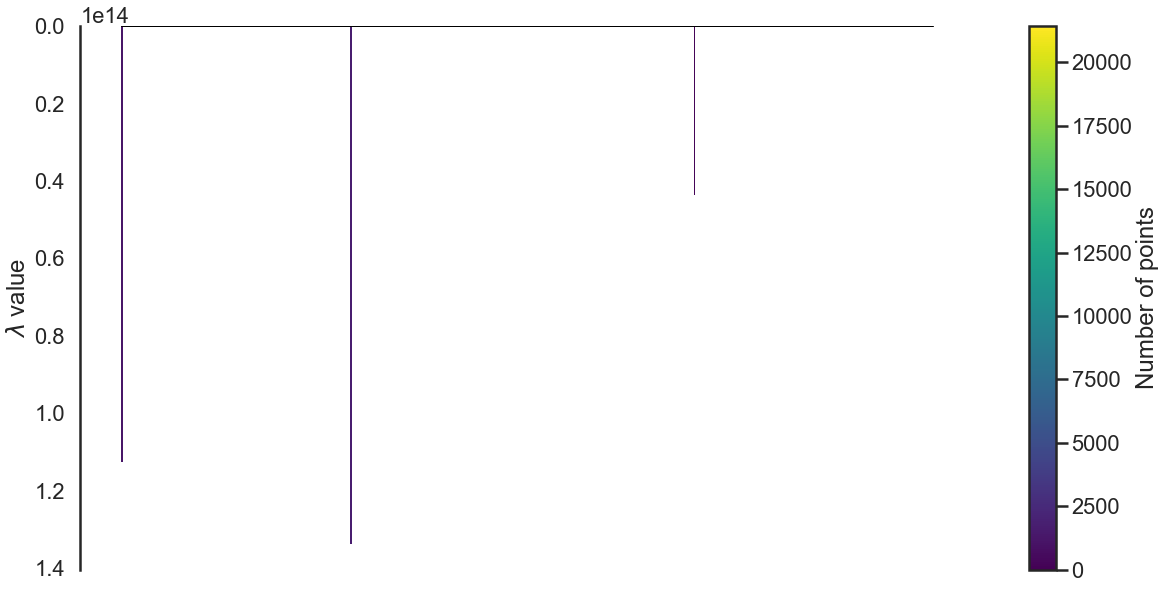

In [64]:
plt.figure(figsize=(20,10))
cluster.condensed_tree_.plot()

## And then we can actually visually represent which clusters are selected

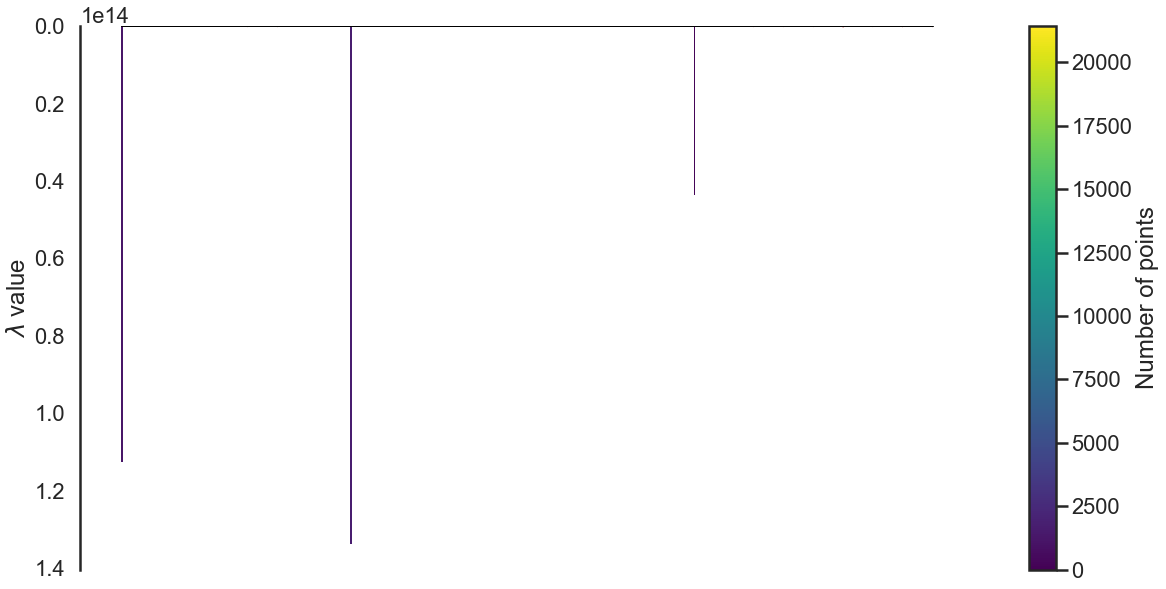

In [65]:
plt.figure(figsize=(20,10))
cluster.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

## Let's look at these clusters back in our original scatterplot

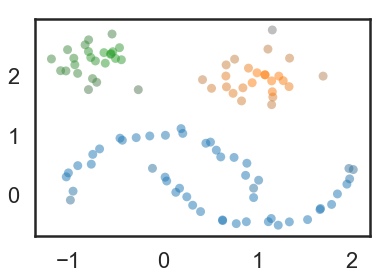

In [9]:
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(test_data.T[0], test_data.T[1], c=cluster_colors, **plot_kwds)

### Using spaCy

In [23]:
nlp = spacy.load('en_core_web_md')

In [24]:
#Function to clean up text
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print(f"Processed {counter} out of {len(docs)} documents.")
        doc = nlp(doc, disable=['parser', 'ner']) #disabling default models of spacy
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']  #Applyint tokenizing and lemmatizing
        tokens = [tok for tok in tokens if tok not in ENGLISH_STOP_WORDS and tok not in string.punctuation] #Removing stopwords and punctuations
        tokens = ' '.join(tokens) 
        texts.append(tokens)  #Appending clean titles to texts list
    return pd.Series(texts)   #Returning texts list as pd Series

In [25]:
cleanup_text(df)

0    text
dtype: object

In [3]:
tweets_clean = cleanup_text(lemm_clean_processed_list)
tweets_clean = ' '.join(lemm_clean_processed_list).split()

tweets_counts = Counter(tweets_clean)

tweets_common_words = [word[0] for word in tweets_counts.most_common(20)]
tweets_common_counts = [word[1] for word in tweets_counts.most_common(20)]
fig = plt.figure(figsize=(18,6))
sns.barplot(x=tweets_common_words, y=tweets_common_counts, palette = "GnBu_d")
sns.set(font_scale=1.5, rc={'figure.figsize':(8, 8)})
plt.title('Most Common Words used in tweets')
plt.show()

ModuleNotFoundError: No module named 'spacy'